# LZIFU: properties of the whole sample

In [1]:
## Imports
import sys
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
from astropy.visualization import hist

from spaxelsleuth.loaddata.lzifu import load_lzifu_galaxies
from spaxelsleuth.loaddata.sami import load_sami_galaxies
from spaxelsleuth.plotting.plot2dmap import plot2dmap
from spaxelsleuth.plotting.sdssimg import plot_sdss_image
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plottools import vmin_fn, vmax_fn, label_fn, cmap_fn
from spaxelsleuth.plotting.plottools import component_colours, ncomponents_colours
from spaxelsleuth.plotting.plotgalaxies import plot2dscatter, plot2dhistcontours

import matplotlib
from matplotlib import rc, rcParams
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rc("text", usetex=False)
rc("font",**{"family": "serif", "size": 14})
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.format"] = "pdf"
plt.ion()
plt.close("all")

In [2]:
# Paths
sami_data_path = "/priv/meggs3/u5708159/SAMI/sami_dr3/"
sami_datacube_path = "/priv/myrtle1/sami/sami_data/Final_SAMI_data/cube/sami/dr3/"
lzifu_data_path = "/priv/meggs3/u5708159/LZIFU/products/"


In [3]:
# Options
fig_path = "/priv/meggs3/u5708159/SAMI/figs/full_sample/"
savefigs = False


In [4]:
# Load the SAMI sample
df_sami = load_sami_galaxies(ncomponents="recom",
                             bin_type="default",
                             eline_SNR_min=5, 
                             vgrad_cut=False,
                             correct_extinction=False,
                             sigma_gas_SNR_cut=True)

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc,

### Load the high-S/N subset

In [5]:
# Load the LZIFU galaxies
df_lzifu = load_lzifu_galaxies(ncomponents="recom",
                              bin_type="default",
                              eline_SNR_min=5, 
                              vgrad_cut=False,
                              correct_extinction=False,
                              sigma_gas_SNR_cut=True)        

Loading LZIFU DataFrame for all galaxies in the LZIFU subsample...


/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/u5708159/python/Modules/spaxelsleuth/loaddata/linefns.py:78: RuntimeWarning: invalid value encountered in add
  return -0.943 * ratio_y_vals**4 - 0.450 * ratio_y_vals**3 + 0.408 * ratio_y_vals**2 - 0.610 * ratio_y_vals - 0.025


# Let's look at the statistics of the subsample
-----
Plot histograms showing:
* redshift distribution
* stellar mass distribution
* spectral classifications 

between the SAMI and LZIFU samples.


### A note on AGN classification
---
We attempted to classify galaxies as AGN using four different criteria:
* BPT, using single-component emission line fits from a 3" nuclear aperture (replicating SDSS);
* WHAN, again using the single-component emission line fits from a 3" nuclear aperture;
* FIR-radio correlation of Mauch & Sadler (2007), where *IRAS* 60 $\mu$m and 100 $\mu$m fluxes were used to compute FIR, and 1.4 GHz flux densities were taken from NVSS;
* *WISE* W1 - W2 criterion of Stern et al. (2012).

We found that these AGN criteria generally did not agree with one another. In particular, practically all galaxies classified as Seyfert using the BPT criterion are not classified as AGN using the MIR *WISE* criterion (in fact, only 5 galaxies in the sample meet the $\rm W1 - W2 \geq 0.8$ condition to be classified as AGN; of these, 3 are star-forming galaxies according to the BPT classification). Furthermore,  there was considerable disagreement between the BPT and WHAN optical classifications: a significant amount of galaxies in the "composite" region of the BPT diagram are WHAN AGN, whereas most galaxies in the LINER/Seyfert region of the BPT diagram are star-forming using the WHAN diagram. 
Meanwhile, fewer than 10 galaxies in our sample have the photometry needed to compute both the FIR and radio fluxes required to classify an AGN using the FIR-radio correlation, rendering it essentially useless. 

In [40]:
# Load the DataFrame that gives us the continuum S/N, to define the subset
df_info = pd.read_hdf(os.path.join(sami_data_path, "sami_dr3_metadata_extended.hd5"))

# Load the DataFrame containing AGN classifications
df_classifications = pd.read_hdf(os.path.join(sami_data_path, "sami_dr3_agn_classifications.hd5"), key="AGN")

# Merge with the metadata DataFrame
new_cols = [c for c in df_classifications.columns if c not in df_info.columns]
df_info = df_info.merge(df_classifications[new_cols], left_index=True, right_index=True)

# Shortlist: median R S/N in 2R_e > 10
gals_subsample = df_info[df_info["Median SNR (R, 2R_e)"] >= 10].index.values

# Add this info to the DataFrames
df_info.loc[:, "In subsample?"] = False
df_info.loc[gals_subsample, "In subsample?"] = True

# Create separate instances of the "info" DataFrame - one for our subset, the other for the full sample
df_all = df_info
df_subset = df_info[df_info["In subsample?"]]

# Sub-subsets by AGN category (optical for now)
df_agn = df_info[df_info["In subsample?"] & (df_info["is AGN (BPT)?"] == "Yes (Seyfert)")]
df_liner = df_info[df_info["In subsample?"] & (df_info["is AGN (BPT)?"] == "Maybe (LINER)")]
df_sf = df_info[df_info["In subsample?"] & (df_info["is AGN (BPT)?"] == "No")]


### Print out some statistics

In [43]:
print("High-S/N LZIFU subsample:")
for ii in range(4):
    print(f"Number of {ii}-component spaxels: {df_lzifu[df_lzifu['Number of components'] == ii].shape[0]}")
          
print("")
print("Full SAMI sample:")
for ii in range(4):
    print(f"Number of {ii}-component spaxels: {df_sami[df_sami['Number of components'] == ii].shape[0]}")
     
print("")
for ii in range(4):
    print(df_lzifu[df_lzifu['Number of components'] == ii].shape[0] / df_sami[df_sami['Number of components'] == ii].shape[0] * 100)

High-S/N LZIFU subsample:
Number of 0-component spaxels: 375691
Number of 1-component spaxels: 108411
Number of 2-component spaxels: 17946
Number of 3-component spaxels: 1826

Full SAMI sample:
Number of 0-component spaxels: 1159462
Number of 1-component spaxels: 629253
Number of 2-component spaxels: 46366
Number of 3-component spaxels: 5074

32.40218308146364
17.228523344346392
38.705085623085886
35.98738667717777


### Histograms showing whether our subsample is biased or not

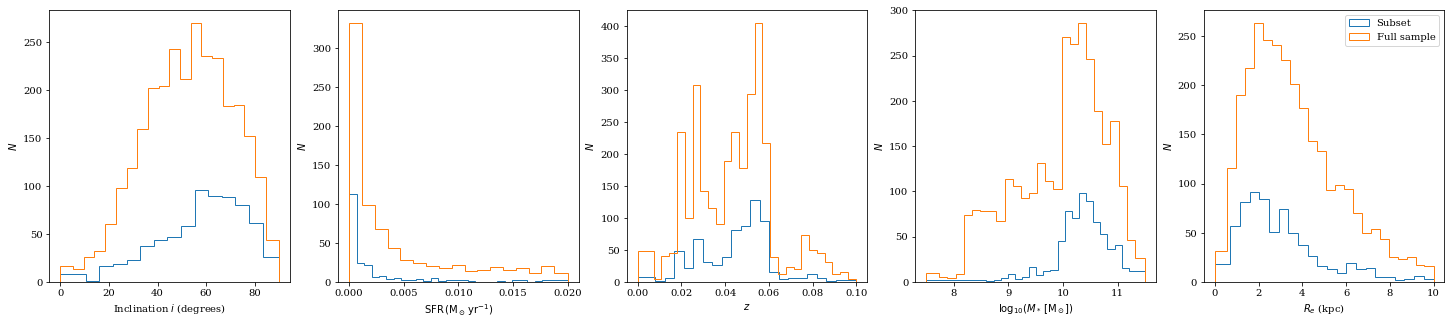

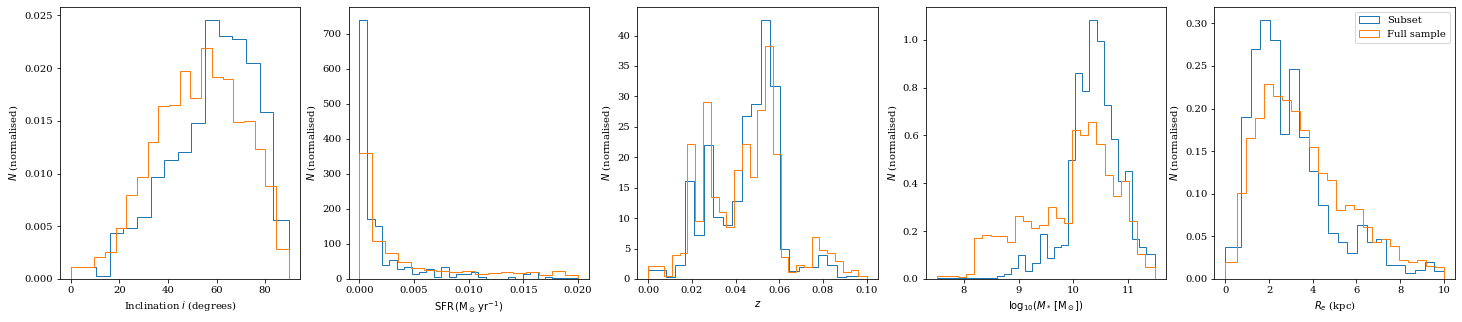

In [44]:
cols = ["Inclination i (degrees)", "SFR (total)", "z_spec", "mstar", "R_e (kpc)"]

######################################################################################
# Non-normalised histograms
######################################################################################
fig, axs = plt.subplots(nrows=1, ncols=len(cols), figsize=(5 * len(cols), 5))
for col, ax in zip(cols, axs):
    # Plot the subset
    _=hist(df_subset[col], histtype="step",
         range=(vmin_fn(col), vmax_fn(col)),
         ax=ax, bins="knuth", label="Subset")
    
    # Plot the full sample
    _=hist(df_all[col], histtype="step",
         range=(vmin_fn(col), vmax_fn(col)),
         ax=ax, bins="knuth", label="Full sample")
    
    # Decorations
    ax.set_xlabel(label_fn(col))
    ax.set_ylabel(r"$N$")
axs[-1].legend()

######################################################################################
# Normalised histograms
######################################################################################
fig, axs = plt.subplots(nrows=1, ncols=len(cols), figsize=(5 * len(cols), 5))
for col, ax in zip(cols, axs):
    # Plot the subset
    _=hist(df_subset[col], histtype="step", density=True,
         range=(vmin_fn(col), vmax_fn(col)),
         ax=ax, bins="knuth", label="Subset")
    
    # Plot the full sample
    _=hist(df_all[col], histtype="step", density=True,
         range=(vmin_fn(col), vmax_fn(col)),
         ax=ax, bins="knuth", label="Full sample")
    
    # Decorations
    ax.set_xlabel(label_fn(col))
    ax.set_ylabel(r"$N$ (normalised)")
axs[-1].legend()

######################################################################################
# Do a KS test to see if our sample is biased
######################################################################################



# Looking at the properties of the emission line components in our subsample
----

### [SII] ratio

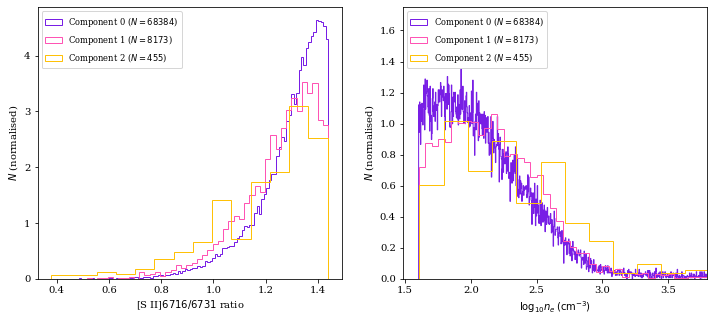

In [57]:
#############################################################################################
# Line ratios
#############################################################################################
# Compute electron denstiy
from spaxelsleuth.loaddata.linefns import Proxauf2014

for ii in range(3):
    df_lzifu[f"n_e (cm^-3) (component {ii})"] = Proxauf2014(df_lzifu[f"S2 ratio (component {ii})"])
    df_lzifu[f"log n_e (cm^-3) (component {ii})"] = np.log10(df_lzifu[f"n_e (cm^-3) (component {ii})"])

# Set up figure
col_list = ["S2 ratio", "log n_e (cm^-3)"]
fig, axs = plt.subplots(nrows=1, ncols=len(col_list), sharey=False, figsize=(12, 5))

if type(axs) != np.ndarray:
    axs = [axs]

for col, ax in zip(col_list, axs if len(axs) == 1 else axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        data = df_lzifu[f"{col} (component {ii})"]
        n = data.count()
        hist(data, histtype="step", density=True,
             ax=ax,
             color=component_colours[ii], bins="knuth", 
             range=(vmin_fn(col), vmax_fn(col)),
             label=f"Component {ii} ($N = {n}$)")
    ax.set_xlabel(label_fn(col))

# Decorations
[ax.set_ylabel(r"$N$ (normalised)") for ax in axs]
[ax.legend(fontsize="small", loc="upper left") for ax in axs]
axs[1].set_xlim([None, 3.8])
axs[1].set_ylim([0, 1.75])

# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_S2_ratio_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


### Histograms line ratios (and other properties) of the components 0, 1 and 2 for the whole sample of high-S/N galaxies

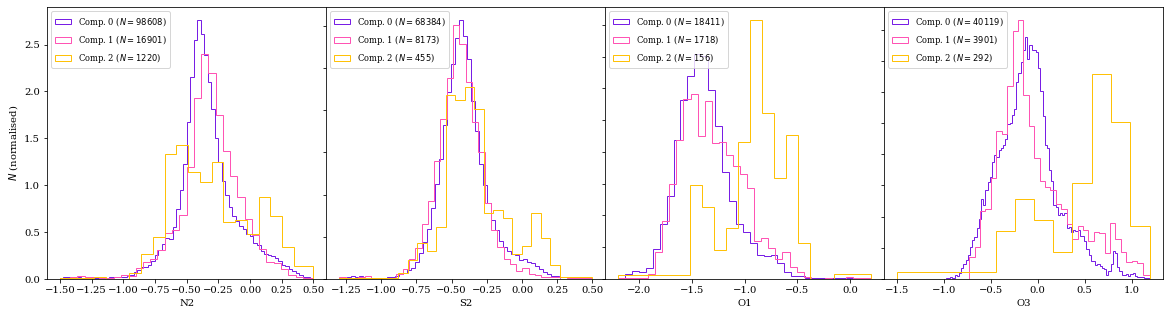

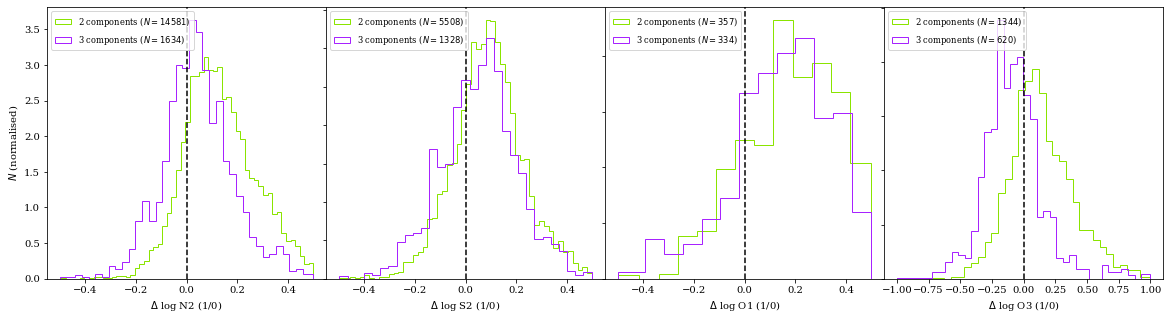

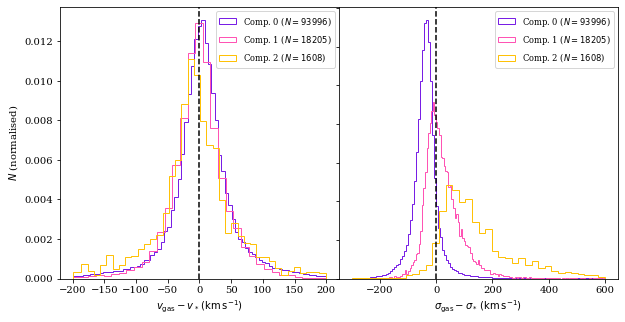

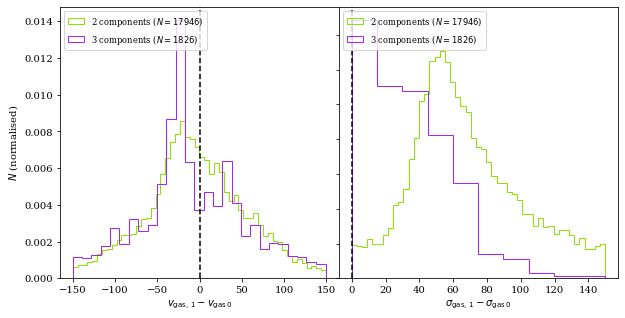

In [67]:
#############################################################################################
# Line ratios
#############################################################################################
# Set up figure
col_list = ["log N2", "log S2", "log O1", "log O3"]
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, figsize=(20, 5))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        data = df_lzifu[f"{col} (component {ii})"]
        n = data.count()
        hist(data, histtype="step", density=True,
             color=component_colours[ii],
             bins="knuth", ax=ax,  
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
              label=f"Comp. {ii} ($N = {n}$)")
    ax.set_xlabel(label_fn(col))

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
[ax.legend(loc="upper left", fontsize="small") for ax in axs]
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_line_ratios_full_sample.pdf"),
                format="pdf", bbox_inches="tight")

#############################################################################################
# Difference in line ratios
#############################################################################################
# Set up figure
col_list = ["delta log N2 (1/0)", "delta log S2 (1/0)", "delta log O1 (1/0)", "delta log O3 (1/0)"]
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, figsize=(20, 5))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for nn in [2, 3]:
        data = df_lzifu.loc[df_lzifu["Number of components"] == nn, f"{col}"]
        n = data.count()
        hist(data, histtype="step", density=True,
             color=ncomponents_colours[nn], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
             label=f"{nn} components ($N = {n}$)")
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
[ax.legend(loc="upper left", fontsize="small") for ax in axs]
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_delta_line_ratios_full_sample.pdf"),
                format="pdf", bbox_inches="tight")

#############################################################################################
# Kinematics
#############################################################################################
# Set up figure
col_list = ["v_gas - v_*", "sigma_gas - sigma_*"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10, 5))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for ii in range(3):
        data = df_lzifu[f"{col} (component {ii})"]
        n = data.count()
        hist(data, histtype="step", density=True,
             color=component_colours[ii], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
             label=f"Comp. {ii} ($N = {n}$)")
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
[ax.legend(loc="upper right", fontsize="small") for ax in axs]
for ax in axs[1:]:
    ax.set_yticklabels([])

# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_kinematics_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


#############################################################################################
# Difference in kinematics
#############################################################################################
# Set up figure
col_list = ["delta v_gas (1/0)", "delta sigma_gas (1/0)"]
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10, 5))
fig.subplots_adjust(wspace=0)

for col, ax in zip(col_list, axs.flat):
    # Plot histograms for the full sample.
    for nn in [2, 3]:
        data = df_lzifu.loc[df_lzifu["Number of components"] == nn, f"{col}"]
        n = data.count()
        hist(data, histtype="step", density=True,
             color=ncomponents_colours[nn], 
             bins="knuth", ax=ax, 
             range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                    +200 if col == "v_gas - v_*" else vmax_fn(col)),
             label=f"{nn} components ($N = {n}$)")
    ax.set_xlabel(label_fn(col))
    ax.axvline(0, color="k", linestyle="--")

# Decorations
axs[0].set_ylabel(r"$N$ (normalised)")
[ax.legend(loc="upper left", fontsize="small") for ax in axs]
for ax in axs[1:]:
    ax.set_yticklabels([])
    
# Save
if savefigs:
    fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_delta_kinematics_full_sample.pdf"),
                format="pdf", bbox_inches="tight")


### Histograms of line ratios (and other properties) of the components 0, 1 and 2 for each galaxy individually

In the figures below, we show histograms of N2, S2, O1, O3 for each kinematic component separately, as well as $\Delta v_{\rm gas 1,0}$ and $\Delta \sigma_{\rm gas 1,0}$.


ValueError: data should have more than three entries

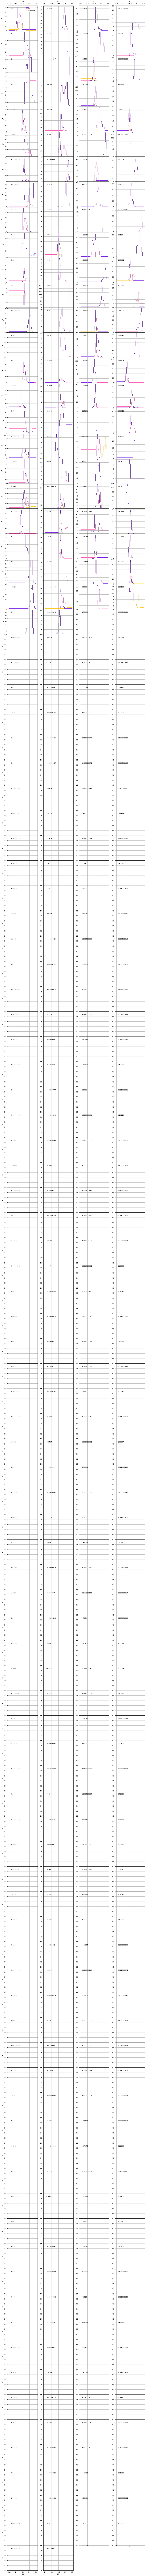

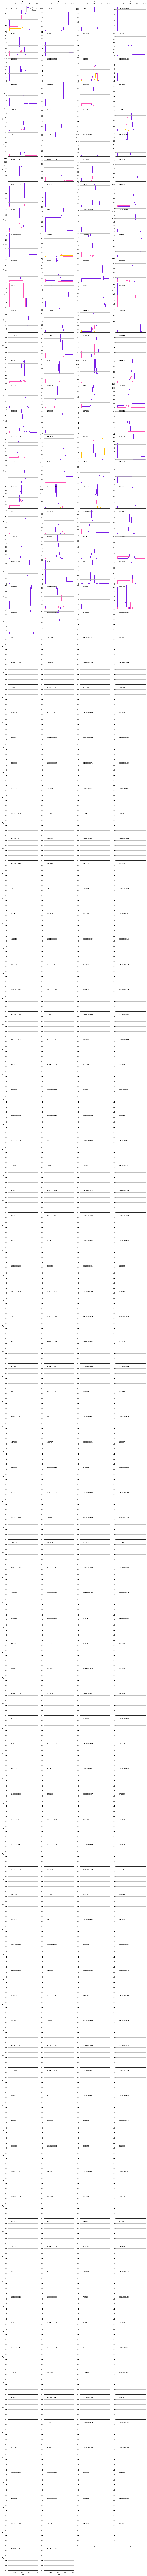

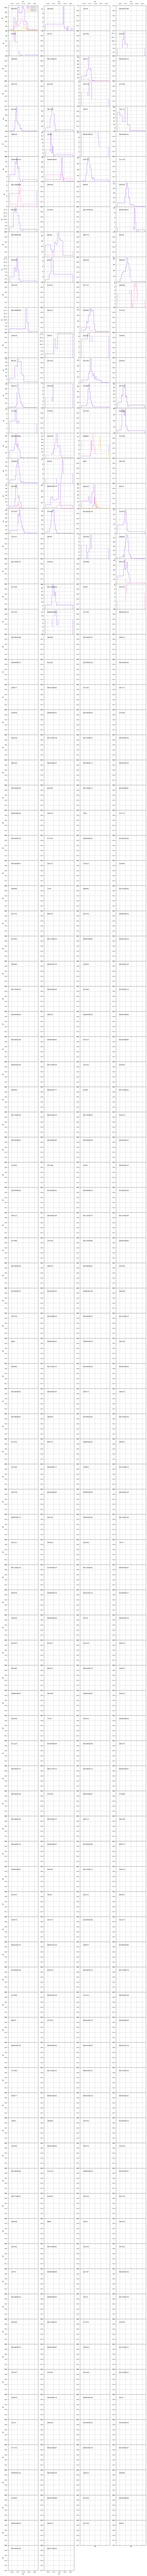

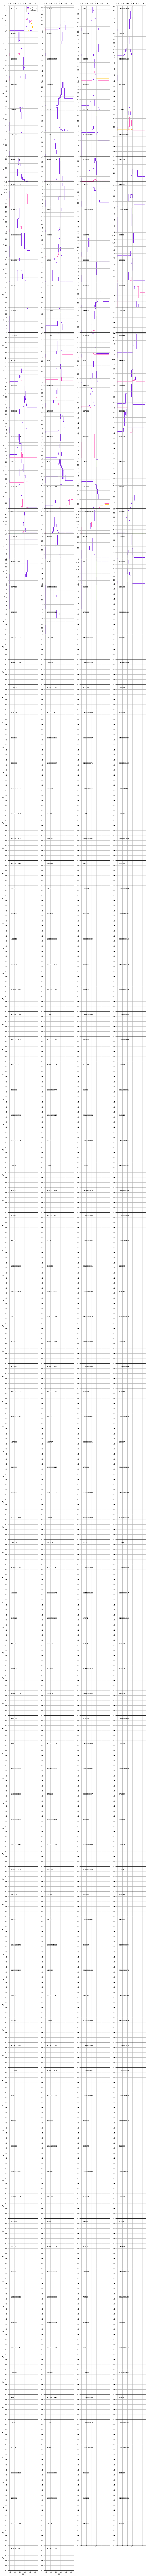

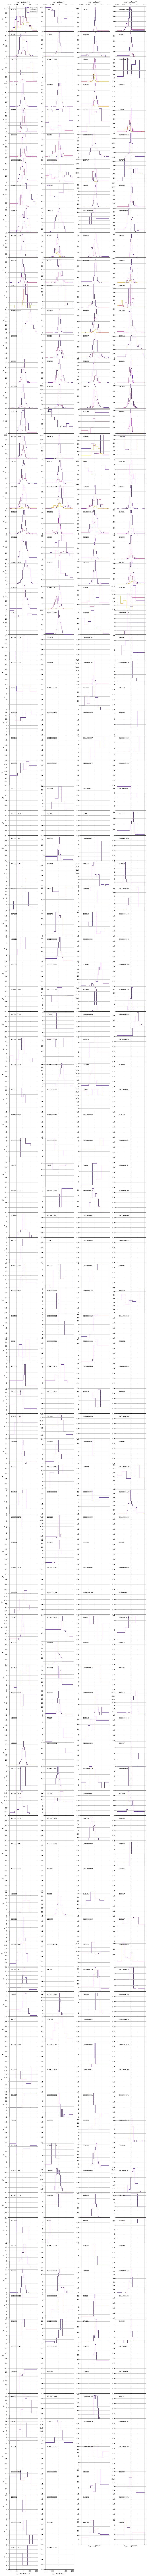

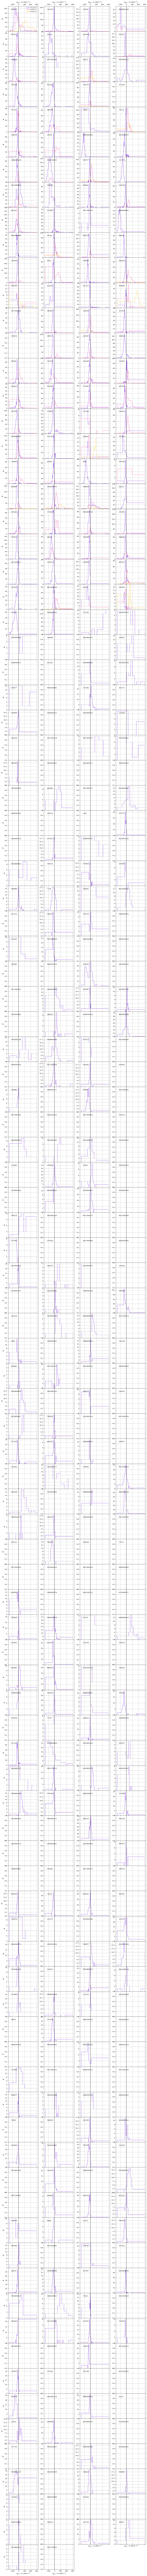

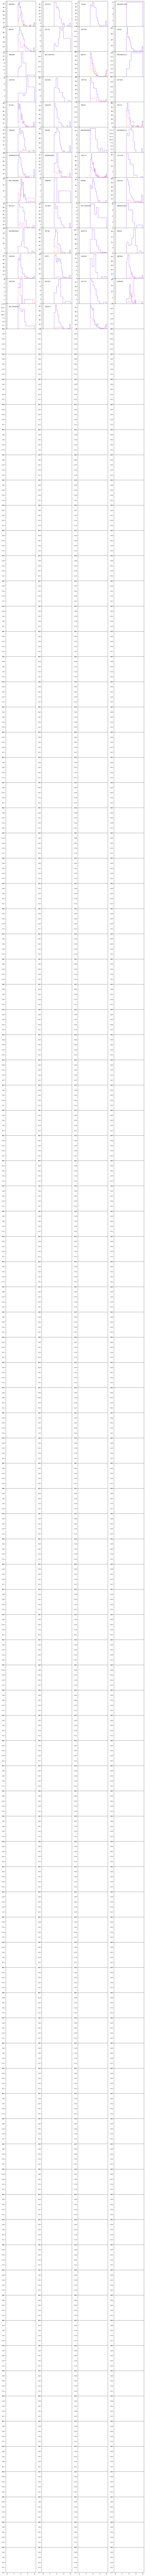

In [28]:
gals = df["catid"].unique()

# For debugging
# gals = gals[:8]

col_list = ["log N2", "log S2", "log O1", "log O3", "v_gas - v_*", "sigma_gas - sigma_*", "log n_e (cm^-3)"]
for col in col_list:
    # Set up figure
    ncols = 4
    nrows = int(np.ceil(len(gals) / float(ncols)))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(4 * ncols, 3 * nrows))
    fig.subplots_adjust(hspace=0)

    # Plot histograms for each galaxy
    for gal, ax in zip(gals, axs.flat):
        df_gal = df[df["catid"] == gal]
        for ii in range(3):
            if df_gal[f"{col} (component {ii})"].count() > 10:
                hist(df_gal[f"{col} (component {ii})"], histtype="step", density=False,
                     color=component_colours[ii], 
                     bins="knuth", ax=ax,
                     range=(-200 if col == "v_gas - v_*" else vmin_fn(col), 
                            +200 if col == "v_gas - v_*" else vmax_fn(col)),
                    label=f"Component {ii}")
        ax.text(s=gal, y=0.9, x=0.1, verticalalignment="top", horizontalalignment="left", transform=ax.transAxes)
        if "-" in col:
            ax.axvline(0, color="k", linestyle="--")
    
    # Decorations
    axs[0][0].legend(loc="upper right", fontsize="x-small")
    for cc in range(ncols):
        axs[0][cc].xaxis.set_tick_params(labeltop='on')
        axs[-1][cc].set_xlabel(label_fn(col))
        axs[0][cc].set_title(label_fn(col), fontsize="medium")
    for rr in range(nrows):
        axs[rr][0].set_ylabel(r"$N$")
    for ax in axs.flat:
        ax.grid()
    for ax in axs.flat[len(gals):]:
        ax.set_visible(False)
    for ax in axs.flat[len(gals) - 4:len(gals)]:
        ax.set_xlabel(label_fn(col))
    
    # Save
    if savefigs:
        fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_{col.replace(' ', '_').replace('*', 'star')}.pdf"),
                    format="pdf", bbox_inches="tight")


### Histograms showing the *difference* between line ratios and kinematic parameters between components 0 and 1

In [ ]:
from IPython.core.debugger import Tracer
gals = df["catid"].unique()

# For debugging
# gals = gals[:8]

for col in ["delta v_gas (1/0)", "delta sigma_gas (1/0)", 
            "delta log N2 (1/0)", "delta log S2 (1/0)", "delta log O1 (1/0)", "delta log O3 (1/0)"]:
    # Set up figure
    ncols = 4
    nrows = int(np.ceil(len(gals) / float(ncols)))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(4 * ncols, 3 * nrows))
    fig.subplots_adjust(hspace=0)

    # Plot histograms for each galaxy
    for gal, ax in zip(gals, axs.flat):
        for nn in [2, 3]:
            df_gal = df[(df["catid"] == gal) & (df["Number of components"] == nn)]
            if not df_gal.empty:
                ax.hist(df_gal[f"{col}"], histtype="step", density=False,
                        color=ncomponents_colours[nn], bins=25, range=(vmin_fn(col), vmax_fn(col)),
                        label=f"{nn} components")              
        ax.text(s=gal, y=0.9, x=0.1, verticalalignment="top", horizontalalignment="left", transform=ax.transAxes)
        ax.axvline(0, color="k", linestyle="--")
        
    # Decorations
    axs[0][0].legend(loc="upper right", fontsize="x-small")
    for cc in range(ncols):
        axs[0][cc].xaxis.set_tick_params(labeltop='on')
        axs[-1][cc].set_xlabel(label_fn(col))
        axs[0][cc].set_title(label_fn(col), fontsize="medium")
    for rr in range(nrows):
        axs[rr][0].set_ylabel(r"$N$")
    for ax in axs.flat:
        ax.grid()
    for ax in axs.flat[len(gals):]:
        ax.set_visible(False)
    for ax in axs.flat[len(gals) - 4:len(gals)]:
        ax.set_xlabel(label_fn(col))
    
    # Save
    if savefigs:
        fig.savefig(os.path.join(fig_path, f"hist_grid_LZIFU_{col.replace(' ', '_').replace('*', 'star').replace('/', '').replace('(', '').replace(')', '')}.pdf"),
                    format="pdf", bbox_inches="tight")


### 2D maps: is there  a correlation between number of components and SFR or $\Sigma_{\rm SFR}$?

In [ ]:
for gal in gals_good:
    # Load LZIFU data
    df_gal = load_lzifu_galaxy(gal=gal, bin_type="default", ncomponents="recom",
                       eline_SNR_min=5,
                       sigma_gas_SNR_cut=True,
                       vgrad_cut=False,
                       stekin_cut=False)
    df_gal.loc[df_gal["Number of components"] == 0, "Number of components"] = np.nan
    
    # Get SAMI data for this galaxy
    df_gal_sami = df_sami[df_sami["catid"] == gal]
    df_gal_sami.loc[df_gal_sami["Number of components"] == 0, "Number of components"] = np.nan

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    # Number of components
    fig = plot2dmap(df_gal=df_gal, bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False, ax=axs[0],
                    plot_colorbar=True, cax_orientation="horizontal")

    # SFR surface density
    fig = plot2dmap(df_gal=df_gal_sami, bin_type="default", survey="sami", 
                    col_z="log SFR surface density", ax=axs[1], show_title=False, 
                    plot_colorbar=True, cax_orientation="horizontal")

    # Plot # of components overlaid with contours showing SFR surface density
    # NOTE: we use df_gal_sami here because the number of components is derived from SAMI DR3 anyway,
    # and log SFR surface density isn't defined in LZIFU
    fig = plot2dmap(df_gal=df_gal_sami,
                    bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False,  ax=axs[2],
                    col_z_contours="SFR surface density", levels=[0.001], linewidths=1, colors="black",
                    plot_colorbar=True, cax_orientation="horizontal")

    # Turn off axis labels
    axs = fig.get_axes()
    for ax in [axs[2], axs[4]]:
        lat = ax.coords[1]
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)


### Recreate Fig. 4 of Arribas+2014: is there a correlation between line ratios and line width?

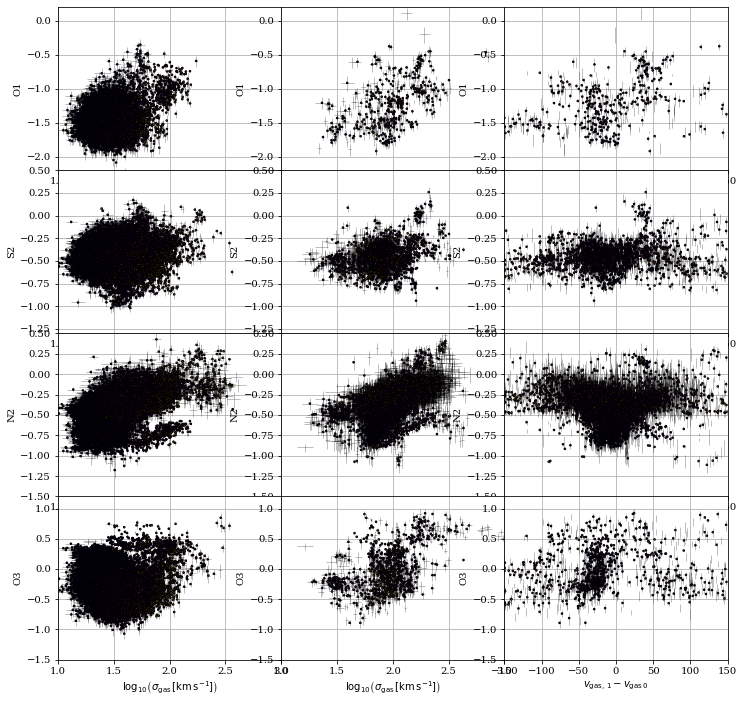

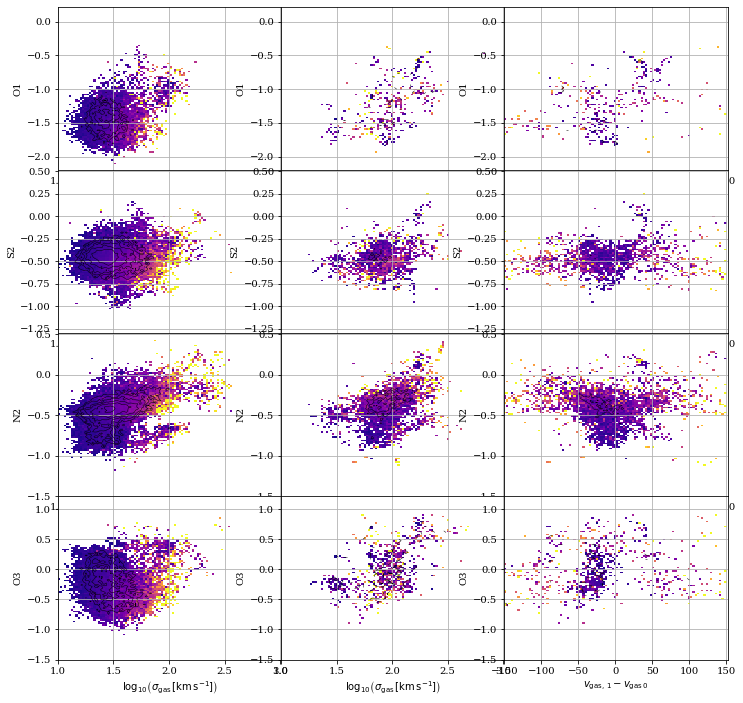

In [15]:
# Scatter plot showing line ratios 
col_y_list = ["log O1", "log S2", "log N2", "log O3"]
col_x_list = ["log sigma_gas (component 0)", "log sigma_gas (component 1)", "delta v_gas (1/0)"]
nrows = len(col_y_list)
ncols = len(col_x_list)

#############################################################################################################
# Represent as scatter plot
#############################################################################################################
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
fig.subplots_adjust(wspace=0, hspace=0)

for rr, col_y in enumerate(col_y_list):
    for cc, col_x in enumerate(col_x_list):
        cx = col_x
        cy = col_y if col_y in df.columns else f"{col_y} (component {0 if cc == 0 else 1})"
        plot2dscatter(df=df, col_x=cx, col_y=cy, col_z=f"v_grad (component {0 if cc == 0 else 1})",
                      ax=axs[rr][cc], plot_colorbar=False,
                      markersize=2.5)
        axs[rr][cc].grid()

#############################################################################################################
# Represent as 2D histogram
#############################################################################################################
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
fig.subplots_adjust(wspace=0, hspace=0)

for rr, col_y in enumerate(col_y_list):
    for cc, col_x in enumerate(col_x_list):
        cx = col_x
        cy = col_y if col_y in df.columns else f"{col_y} (component {0 if cc == 0 else 1})"
        plot2dhistcontours(df=df, col_x=cx, col_y=cy, col_z=f"v_grad (component {0 if cc == 0 else 1})", log_z=False,
                           ax=axs[rr][cc], plot_colorbar=False)
        axs[rr][cc].grid()
